In [11]:
!pip install pandas
!pip install numpy
!pip install -U scikit-learn

import numpy as np 
import pandas as pd 
from sklearn.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Dropout, MaxPooling2D, Flatten, Rescaling
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt


import os
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [12]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [13]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [44]:
# main_dir = "/kaggle/input/ai-generated-images-vs-real-images/"
train_dir = "/tf/notebooks/ai_images_vs_real_image/train"
test_dir = "/tf/notebooks/ai_images_vs_real_image/test"
batch_size = 64
image_height = 224
image_width = 224
num_channels = 3

In [45]:
!pwd

/tf/notebooks


In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                train_dir,
                seed=42,
                image_size=(image_height, image_width),
                batch_size=batch_size
            )

Found 875 files belonging to 2 classes.


In [47]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
                test_dir,
                seed=42,
                image_size=(image_height, image_width),
                batch_size=batch_size
            )

Found 96 files belonging to 2 classes.


In [48]:
train_class_names = train_ds.class_names
print(train_class_names)
num_classes_train = len(train_class_names)
print(num_classes_train)

['AiArtData', 'RealArt']
2


In [49]:
test_class_names = valid_ds.class_names
print(test_class_names)
num_classes_test = len(test_class_names)
print(num_classes_test)

['AiArtData', 'RealArt']
2


2024-04-28 09:33:10.731306: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
2024-04-28 09:33:13.379038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


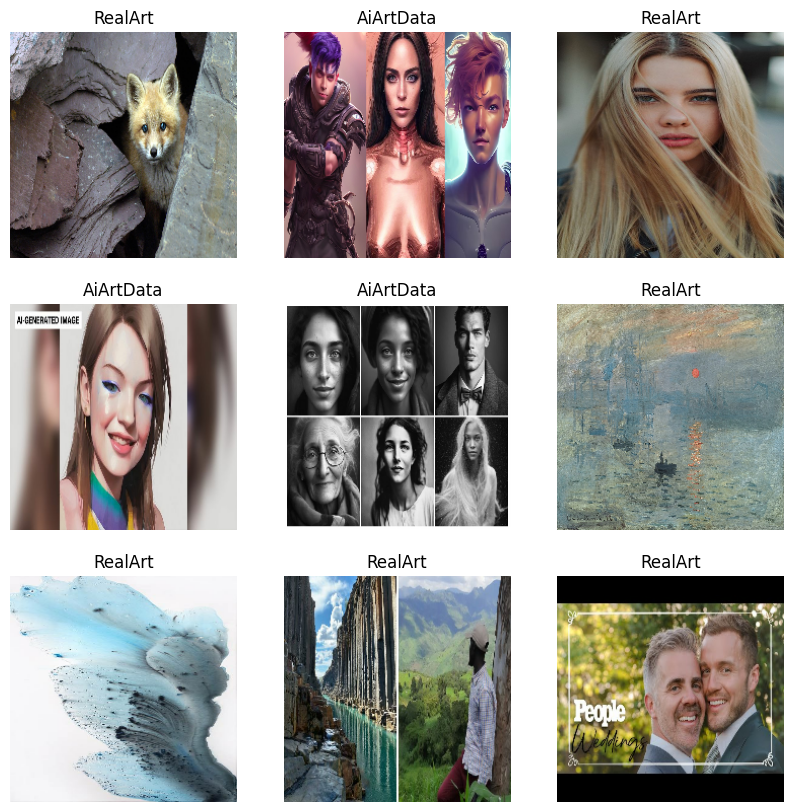

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i]])
        plt.axis("off")

In [52]:
normalization_layer =  Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
def plot_training_history(history, accuracy = 'accuracy'):
    train_acc = history.history[accuracy]
    train_loss = history.history['loss']

    val_acc = history.history['val_' + accuracy]
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    val_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(train_acc))]

    loss_label = f'Best epochs = {str(index_loss +1)}'
    acc_label = f'Best epochs = {str(index_acc + 1)}'

    # Training history
    plt.figure(figsize= (20,8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1,2,1)
    plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
    plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
    plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
    plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
    plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [55]:
num_classes = len(train_class_names)

# Define the CNN model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(num_classes)
])


optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,loss=loss,metrics=['sparse_categorical_accuracy'])

In [56]:
# Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# lr=1e-4
# epochs = 30
# optimizer = Adam(learning_rate = lr, decay = lr/epochs)

# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [57]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
                                                      monitor='val_sparse_categorical_accuracy', 
                                                      save_best_only=True, 
                                                      mode='max', 
                                                      verbose=1)

In [58]:
# Train the model with early stopping
history = model.fit(train_ds,
                    epochs=50, 
                    validation_data=valid_ds, 
                    callbacks=[ model_checkpoint])

Epoch 1/50


2024-04-28 09:33:46.039888: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
2024-04-28 09:33:50.999715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38535424 bytes after encountering the first element of size 38535424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.9469 - sparse_categorical_accuracy: 0.5171
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.54167, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 2.8679 - sparse_categorical_accuracy: 0.5191 - val_loss: 0.6808 - val_sparse_categorical_accuracy: 0.5417
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6254 - sparse_categorical_accuracy: 0.6715
Epoch 2: val_sparse_categorical_accuracy improved from 0.54167 to 0.58333, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.6242 - sparse_categorical_accuracy: 0.6723 - val_loss: 0.6815 - val_sparse_categorical_accuracy: 0.5833
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5695 - sparse_categorical_accuracy: 0.7224
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.58333
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.6814 - val

### Plotting training curve

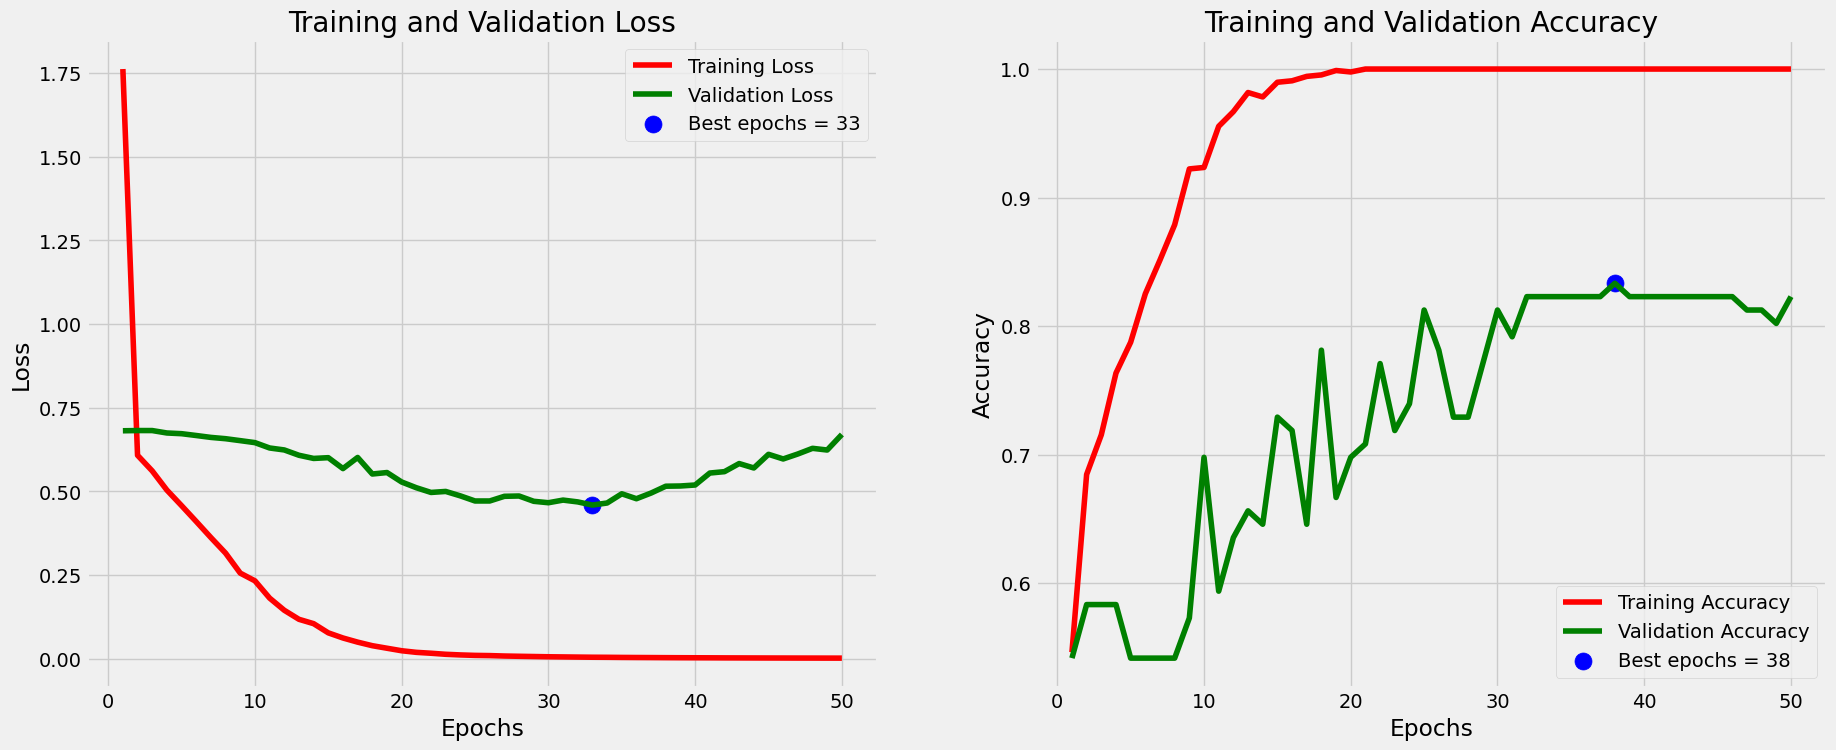

In [60]:
plot_training_history(history, 'sparse_categorical_accuracy')

In [61]:
# Load the saved model
model = load_model("/tf/notebooks/best_model.keras")

In [62]:
# Assuming X_test contains the test data
# Make predictions on the test data
logits = model.predict(valid_ds)
probabilities = tf.nn.softmax(logits).numpy()
# predictions contain the probability distribution over classes for each sample
# To get the predicted class labels, you can use argmax
predicted_labels = tf.argmax(probabilities, axis=1)

# Print the predicted labels
print(predicted_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step
tf.Tensor(
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0
 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0], shape=(96,), dtype=int64)


In [63]:
true_indices = []
for i, record in enumerate(valid_ds.unbatch()):
    image, label = record
    true_indices.append(label.numpy())
    
len(true_indices)

2024-04-28 09:49:44.351116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


96

In [64]:
# Calculate accuracy
accuracy = accuracy_score(true_indices, predicted_labels)
print("Accuracy:", accuracy)

# Calculate F1 score
score_f1 = f1_score(true_indices, predicted_labels)
print("\nF1 Score:", score_f1)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_indices, predicted_labels))

Accuracy: 0.8333333333333334

F1 Score: 0.8048780487804879

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        52
           1       0.87      0.75      0.80        44

    accuracy                           0.83        96
   macro avg       0.84      0.83      0.83        96
weighted avg       0.84      0.83      0.83        96

